In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("classic")

In [3]:
def strompreis (Anfangsstrompreis, Energiepreissteigerung):
    preis = [Anfangsstrompreis]
    for i in range (14):
        preis.append(preis[i]*Energiepreissteigerung)
    return preis

In [4]:
def gaspreis (Anfangsgaspreis, Energiepreissteigerung):
    preis = [Anfangsgaspreis]
    for i in range (14):
        preis.append(preis[i]*Energiepreissteigerung)
    return preis

In [5]:
def pelletpreis (Anfangspelletpreis, Energiepreissteigerung):
    preis = [Anfangspelletpreis]
    for i in range (14):
        preis.append(preis[i]*Energiepreissteigerung)
    return preis

In [6]:
def energiepreis(preis_pro_kwh, bedarf_in_kwh, JAZ):
    preis=[]
    for i in range(15):
        preis.append(preis_pro_kwh[i]*(bedarf_in_kwh/JAZ))
    return preis

In [7]:
def co2ausstoss(ausstoss_spezifisch, energiebedarf, JAZ):
    ausstoss_absolut=[]
    for i in range (15):
        ausstoss_absolut.append((ausstoss_spezifisch[i]*(energiebedarf/JAZ))/1000000)
    return ausstoss_absolut

In [8]:
def co2steuer(CO2_Steuer, co2ausstoss):
    steuer=[]
    for i in range(15):
        steuer.append(CO2_Steuer[i]*(co2ausstoss[i]))
    return steuer

In [9]:
def gesamtco2(CO2_Ausstoss):
    gesamt=[CO2_Ausstoss[0]]
    for i in range(14):
        gesamt.append(gesamt[i]+CO2_Ausstoss[i+1])
    return gesamt

In [10]:
def gesamtkosten(Investkosten, Kosten_pro_Jahr):
    gesamt=[Investkosten+Kosten_pro_Jahr[0]]
    for i in range(14):
        gesamt.append(gesamt[i]+Kosten_pro_Jahr[i+1])
    return gesamt

In [11]:
def allgemeines(CO2_Steuer,Strommix_Erneuerbar,CO2_Strom_GEG,CO2_Strom_real,CO2_Gas_GEG, Anfangsstrompreis,Energiepreissteigerung,Anfangsgaspreis,Anfangspelletpreis):
    Allgemeines = pd.DataFrame({'CO2_Steuer': CO2_Steuer,
                      'Strommix_Erneuerbar':Strommix_Erneuerbar,
                      'CO2_Strom_GEG': CO2_Strom_GEG, 
                      'CO2_Strom_real':CO2_Strom_real,
                      'CO2_Gas': CO2_Gas_GEG, 
                      'Strompreis': strompreis (Anfangsstrompreis, Energiepreissteigerung),
                      'Gaspreis':gaspreis (Anfangsgaspreis, Energiepreissteigerung),
                      'Pelletpreis':pelletpreis (Anfangspelletpreis, Energiepreissteigerung)
                      })
    return Allgemeines

In [12]:
def Wärmepumpe(Heiwärmebedarf,TWW_Bedarf, Strompreis,JAZ, Investkosten, Wartungskosten, CO2_Strom_real, CO2_Strom_GEG, CO2_Steuer):
    Energiebedarf = Heiwärmebedarf + TWW_Bedarf
    WP = pd.DataFrame({'Energiekosten':energiepreis(Strompreis, Energiebedarf, JAZ),
                      'Wartungskosten':(Investkosten*Wartungskosten),
                      'CO2_Ausstoss_real':co2ausstoss(CO2_Strom_real, Energiebedarf, JAZ),
                      'CO2_Ausstoss_GEG':co2ausstoss(np.full(shape=15,fill_value=CO2_Strom_GEG), Energiebedarf, JAZ),
                      })
    WP['CO2_Ausstoss_Gesamt'] = gesamtco2(WP["CO2_Ausstoss_real"])
    WP['CO2_Steuer_real'] = co2steuer(CO2_Steuer, WP["CO2_Ausstoss_real"])
    WP['CO2_Steuer_GEG'] = co2steuer(CO2_Steuer, WP["CO2_Ausstoss_GEG"])
    WP['Kosten_pro_Jahr'] = (WP['Energiekosten']+WP["Wartungskosten"]+WP["CO2_Steuer_real"])
    WP['Gesamtkosten'] = gesamtkosten(Investkosten, WP['Kosten_pro_Jahr'])
    return WP

In [13]:
def Brennwert(Heiwärmebedarf,TWW_Bedarf, Gaspreis,JAZ, Investkosten, Wartungskosten, CO2_Gas, CO2_Steuer):
    Energiebedarf = Heiwärmebedarf + TWW_Bedarf
    Brennwert = pd.DataFrame({'Energiekosten':energiepreis(Gaspreis, Energiebedarf, JAZ),
                      'Wartungskosten':(Investkosten*Wartungskosten),
                      'CO2_Ausstoss_GEG':co2ausstoss(np.full(shape=15,fill_value=CO2_Gas), Energiebedarf, JAZ),
                      })
    Brennwert['CO2_Ausstoss_Gesamt'] = gesamtco2(Brennwert["CO2_Ausstoss_GEG"])
    Brennwert['CO2_Steuer_GEG'] = co2steuer(CO2_Steuer, Brennwert["CO2_Ausstoss_GEG"])
    Brennwert['Kosten_pro_Jahr'] = (Brennwert['Energiekosten']+Brennwert["Wartungskosten"]+Brennwert["CO2_Steuer_GEG"])
    Brennwert['Gesamtkosten'] = gesamtkosten(Investkosten, Brennwert['Kosten_pro_Jahr'])
    return Brennwert

In [14]:
def PV_ergänzen(Wärmeerzeuger, Allgemeines, Stromertrag_PV, Eigennutzungsgrad_PV, Investkosten, Investkosten_PV, Wartungskosten, CO2_Steuer):
    Wärmeerzeuger_PV = Wärmeerzeuger.copy()
    invest = Investkosten + Investkosten_PV
    for i in range(15):
        Wärmeerzeuger_PV["Energiekosten"].iloc[i] = Wärmeerzeuger["Energiekosten"].iloc[i] - (Allgemeines["Strompreis"].iloc[i]*Stromertrag_PV*Eigennutzungsgrad_PV)
        Wärmeerzeuger_PV["Wartungskosten"].iloc[i] = Wärmeerzeuger["Wartungskosten"].iloc[i] + Investkosten_PV*Wartungskosten
        Wärmeerzeuger_PV["CO2_Ausstoss_real"].iloc[i] = Wärmeerzeuger["CO2_Ausstoss_real"].iloc[i] * (1-Eigennutzungsgrad_PV)
        Wärmeerzeuger_PV["CO2_Ausstoss_GEG"].iloc[i] = Wärmeerzeuger["CO2_Ausstoss_GEG"].iloc[i] * (1-Eigennutzungsgrad_PV)

    Wärmeerzeuger_PV['CO2_Steuer_real'] = co2steuer(CO2_Steuer, Wärmeerzeuger_PV["CO2_Ausstoss_real"])
    Wärmeerzeuger_PV['CO2_Steuer_GEG'] = co2steuer(CO2_Steuer, Wärmeerzeuger_PV["CO2_Ausstoss_GEG"])    
    Wärmeerzeuger_PV['CO2_Ausstoss_Gesamt'] = gesamtco2(Wärmeerzeuger_PV["CO2_Ausstoss_real"])    
    Wärmeerzeuger_PV['Kosten_pro_Jahr'] = Wärmeerzeuger_PV['Energiekosten'] + Wärmeerzeuger_PV["Wartungskosten"] + Wärmeerzeuger_PV["CO2_Steuer_real"]
    Wärmeerzeuger_PV['Gesamtkosten'] = gesamtkosten(invest, Wärmeerzeuger_PV['Kosten_pro_Jahr'])
    return Wärmeerzeuger_PV

In [15]:
Energiepreissteigerung = 1.03 # 3% Energiepreissteigerung pro Jahr
Heiwärmebedarf = 6000 # Heizung Endenergiebedarf
TWW_Bedarf = 3000 # Warmwasser Endenergiebedarf
JAZ_LWWP = 3.2 # Jahres Arbeitszahl für die Luft-Wasser-Wärmepumpe
JAZ_SWWP = 4.5 # Jahres Arbeitszahl für die Sole-Wasser-Wärmepumpe
Wartungskosten = 0.015 # 1,5 % Wartungskosten pro Jahr
# PV_______________________________________________________________________________
Stromertrag_PV = 4000 # Eine ca. 4 kWp-Anlage
Eigennutzungsgrad_PV = 0.3 # 30% des erzeugten Stroms werden selbst genutzt. Der Rest wird verkauft.
Investkosten_PV = 4600 # für 4 kWp
#__________________________________________________________________________________
Anfangsstrompreis = 0.30 # 30 Cent
Anfangsgaspreis = 0.06 # 6 Cent
Anfangspelletpreis = 0.05 # 5 Cent
CO2_Strom_GEG = 560 # Laut GEG gibt es 560 g CO2-Emissionen pro kWh Stromverbrauch
CO2_Gas_GEG = 240 # Laut GEG gibt es 240 g CO2-Emissionen pro kWh Gasverbrauch
CO2_Holz_GEG = 20 # Laut GEG gibt es 20 g CO2-Emissionen pro kWh Holz
Investkosten_LWWP = 6000 # Anschaffungspreis der Luft-Wasser-Wärmepumpe
Investkosten_Brennwert = 4500 # Anschaffungspreis des Gas-Brennwert-Geräts
Investkosten_SWWP = 16500 # Anschaffungspreis der Sole-Wasser-Wärmepumpe
Investkosten_Eisspeicher = 16500 # Anschaffungspreis des Eisspeichers
Investkosten_Pelletkessel = 14000 # Anschaffungspreis des Pellet-Kessels
Investkosten_Solarthermie = 2500 # Anschaffungspreis der Solarthermie-Anlage
# Die ersten Werte der VO2 Steuer bis 55 sind fix geplant so. Der Rest ist eine Annahme
# CO2_Steuer = [25,30,35,45,55,65,75,77,79,81,79,77,75,75,74] # In € pro Tonne für 15 Jahre Variante billig
CO2_Steuer = [25,30,35,45,55,65,75,85,95,105,115,125,135,145,155] # In € pro Tonne für 15 Jahre Variante teuer
# Ich nehme an, dass der erneuerbare Anteil am Stromnetz um 2% pro Jahr steigt
Strommix_Erneuerbar = np.arange(45,75,2) # Findet gar keine Verwendung derzeit
# Ich nehme an, dass der reale CO2-Ausstoß pro kWh Strom jährlich um 5% sinkt:
CO2_Strom_real = [475]
for i in range(14):
    CO2_Strom_real.append(CO2_Strom_real[i]*0.95) 
Allgemeines = allgemeines(CO2_Steuer,Strommix_Erneuerbar,CO2_Strom_GEG,CO2_Strom_real,CO2_Gas_GEG, 
                          Anfangsstrompreis,Energiepreissteigerung,Anfangsgaspreis,Anfangspelletpreis)

In [16]:
Luftpumpe = Wärmepumpe(Heiwärmebedarf,TWW_Bedarf, Allgemeines["Strompreis"],JAZ_LWWP, Investkosten_LWWP, 
     Wartungskosten, Allgemeines["CO2_Strom_real"], Allgemeines["CO2_Strom_GEG"], 
     Allgemeines["CO2_Steuer"])

In [17]:
Erdpumpe = Wärmepumpe (Heiwärmebedarf,TWW_Bedarf, Allgemeines["Strompreis"],JAZ_SWWP, Investkosten_SWWP, 
     Wartungskosten, Allgemeines["CO2_Strom_real"], Allgemeines["CO2_Strom_GEG"], 
     Allgemeines["CO2_Steuer"])

In [18]:
Gasbrennwert = Brennwert(Heiwärmebedarf,TWW_Bedarf, Allgemeines["Gaspreis"],1, Investkosten_Brennwert, 
                         Wartungskosten, Allgemeines['CO2_Gas'], Allgemeines["CO2_Steuer"])

In [19]:
Brennwert_Sol = Brennwert(Heiwärmebedarf,TWW_Bedarf*0.5, Allgemeines["Gaspreis"],1,
                                  Investkosten_Brennwert+Investkosten_Solarthermie, Wartungskosten,
                                  Allgemeines['CO2_Gas'], Allgemeines["CO2_Steuer"])

In [20]:
Luftpumpe_PV =  PV_ergänzen(Luftpumpe, Allgemeines, Stromertrag_PV, Eigennutzungsgrad_PV, 
                              Investkosten_LWWP, Investkosten_PV,Wartungskosten, 
                              Allgemeines["CO2_Steuer"])

In [21]:
Erdpumpe_PV =  PV_ergänzen(Erdpumpe, Allgemeines, Stromertrag_PV, Eigennutzungsgrad_PV, 
                              Investkosten_SWWP, Investkosten_PV,Wartungskosten, 
                              Allgemeines["CO2_Steuer"])

In [22]:
Luftpumpe

,Energiekosten,Wartungskosten,CO2_Ausstoss_real,CO2_Ausstoss_GEG,CO2_Ausstoss_Gesamt,CO2_Steuer_real,CO2_Steuer_GEG,Kosten_pro_Jahr,Gesamtkosten
0,843.750000,90.0,1.335938,1.575,1.335938,33.398438,39.375,967.148438,6967.148438
1,869.062500,90.0,1.269141,1.575,2.605078,38.074219,47.250,997.136719,7964.285156
2,895.134375,90.0,1.205684,1.575,3.810762,42.198926,55.125,1027.333301,8991.618457
3,921.988406,90.0,1.145399,1.575,4.956161,51.542974,70.875,1063.531380,10055.149837
4,949.648058,90.0,1.088129,1.575,6.044291,59.847119,86.625,1099.495178,11154.645015
5,978.137500,90.0,1.033723,1.575,7.078014,67.191993,102.375,1135.329493,12289.974508
6,1007.481625,90.0,0.982037,1.575,8.060050,73.652762,118.125,1171.134387,13461.108895
7,1037.706074,90.0,0.932935,1.575,8.992985,79.299473,133.875,1207.005547,14668.114442
8,1068.837256,90.0,0.886288,1.575,9.879274,84.197382,149.625,1243.034638,15911.149081
9,1100.902374,90.0,0.841974,1.575,10.721247,88.407251,165.375,1279.309625,17190.458706


In [23]:
print("Luftpumpe ",round(Luftpumpe["Gesamtkosten"].iloc[-1]))
print("Erdpumpe ",round(Erdpumpe["Gesamtkosten"].iloc[-1]))
print("Gasbrennwert ",round(Gasbrennwert["Gesamtkosten"].iloc[-1]))
print("Brennwert_Solar ",round(Brennwert_Sol["Gesamtkosten"].iloc[-1]))
print("Luftpumpe_PV ",round(Luftpumpe_PV["Gesamtkosten"].iloc[-1]))
print("Erdpumpe_PV ",round(Erdpumpe_PV["Gesamtkosten"].iloc[-1]))

Luftpumpe  24145
Erdpumpe  32156
Gasbrennwert  18342
Brennwert_Solar  19267
Luftpumpe_PV  22754
Erdpumpe_PV  30860


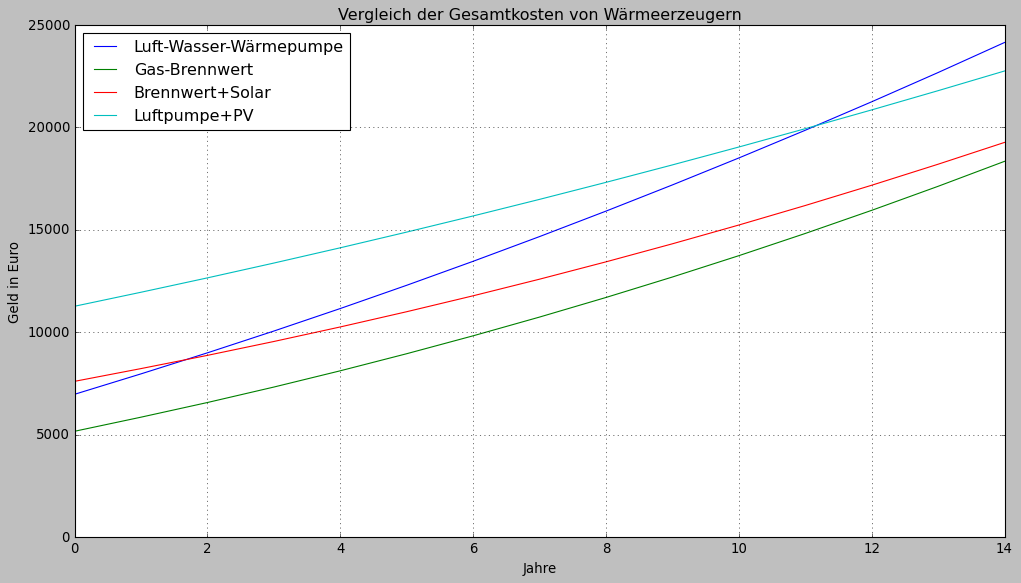

In [24]:
Luftpumpe["Gesamtkosten"].plot(figsize=(15,8), legend=True, label= "Luft-Wasser-Wärmepumpe")
#Erdpumpe["Gesamtkosten"].plot(figsize=(15,8), legend=True, label= "Sole-Wasser-Wärmepumpe")
Gasbrennwert["Gesamtkosten"].plot(figsize=(15,8), legend=True, label= "Gas-Brennwert")
Brennwert_Sol["Gesamtkosten"].plot(figsize=(15,8), legend=True, label= "Brennwert+Solar")
Luftpumpe_PV["Gesamtkosten"].plot(figsize=(15,8), legend=True, label= "Luftpumpe+PV")
#Erdpumpe_PV["Gesamtkosten"].plot(figsize=(15,8), legend=True, label= "Erdpumpe+PV")
plt.xlabel("Jahre")
plt.ylabel("Geld in Euro")
plt.ylim(0)
plt.xlim(0)
plt.grid()
plt.title("Vergleich der Gesamtkosten von Wärmeerzeugern") 
plt.show()

In [25]:
print(Luftpumpe["CO2_Ausstoss_real"].sum())
print(Erdpumpe["CO2_Ausstoss_real"].sum())
print(Gasbrennwert["CO2_Ausstoss_GEG"].sum())
print(Brennwert_Sol["CO2_Ausstoss_GEG"].sum())
print(Luftpumpe_PV["CO2_Ausstoss_real"].sum())
print(Erdpumpe_PV["CO2_Ausstoss_real"].sum())

14.340187444169086
10.197466626964683
32.400000000000006
27.000000000000004
10.038131210918358
7.138226638875277


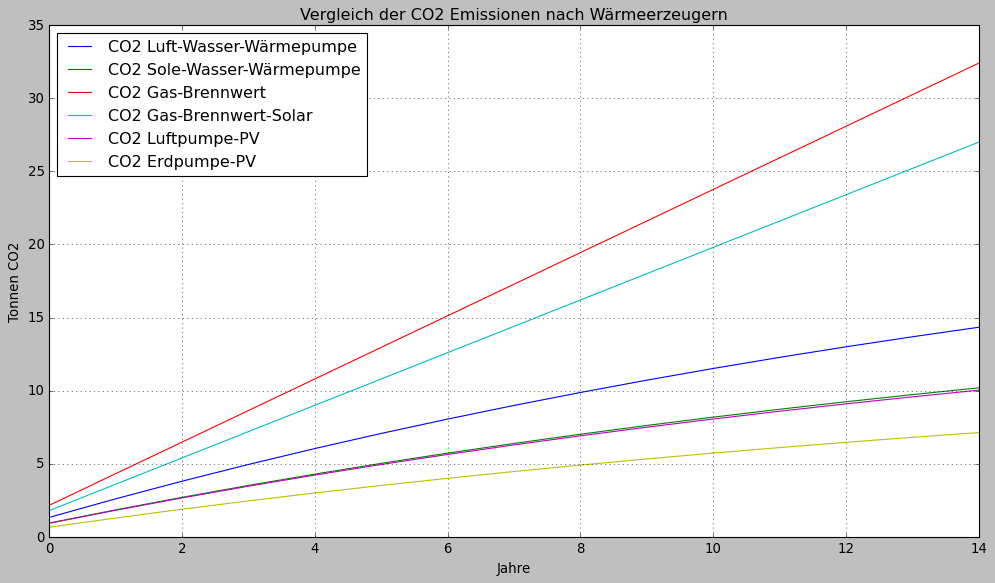

In [26]:
Luftpumpe["CO2_Ausstoss_Gesamt"].plot(figsize=(15,8), legend=True, label= "CO2 Luft-Wasser-Wärmepumpe")
Erdpumpe["CO2_Ausstoss_Gesamt"].plot(figsize=(15,8), legend=True, label= "CO2 Sole-Wasser-Wärmepumpe")
Gasbrennwert["CO2_Ausstoss_Gesamt"].plot(figsize=(15,8), legend=True, label= "CO2 Gas-Brennwert")
Brennwert_Sol["CO2_Ausstoss_Gesamt"].plot(figsize=(15,8), legend=True, label= "CO2 Gas-Brennwert-Solar")
Luftpumpe_PV["CO2_Ausstoss_Gesamt"].plot(figsize=(15,8), legend=True, label= "CO2 Luftpumpe-PV")
Erdpumpe_PV["CO2_Ausstoss_Gesamt"].plot(figsize=(15,8), legend=True, label= "CO2 Erdpumpe-PV")
plt.xlabel("Jahre")
plt.ylabel("Tonnen CO2")
#plt.ylim(0,3)
#plt.xlim(0,15)
plt.grid()
plt.title("Vergleich der CO2 Emissionen nach Wärmeerzeugern") 
plt.show()

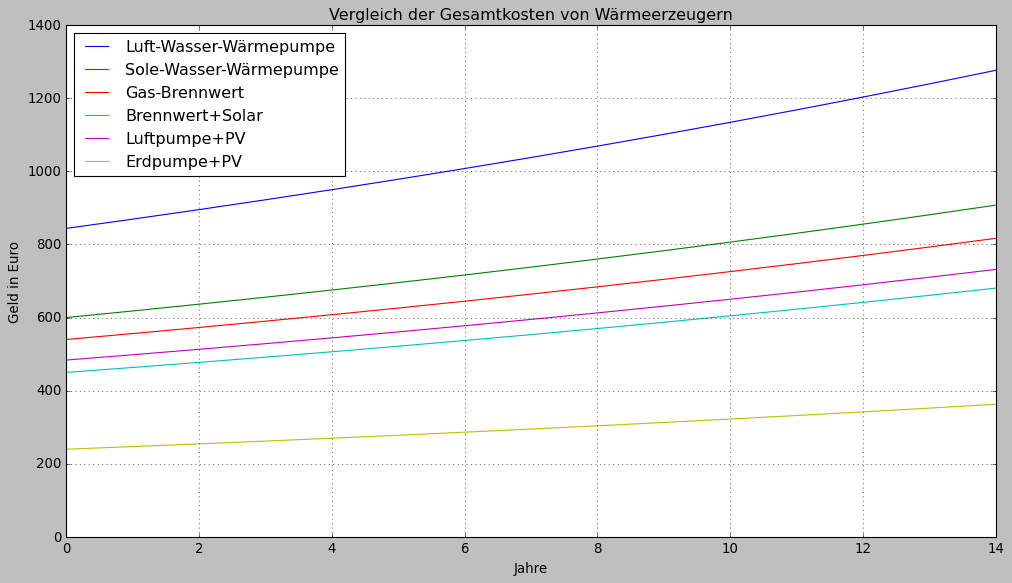

In [27]:
Luftpumpe["Energiekosten"].plot(figsize=(15,8), legend=True, label= "Luft-Wasser-Wärmepumpe")
Erdpumpe["Energiekosten"].plot(figsize=(15,8), legend=True, label= "Sole-Wasser-Wärmepumpe")
Gasbrennwert["Energiekosten"].plot(figsize=(15,8), legend=True, label= "Gas-Brennwert")
Brennwert_Sol["Energiekosten"].plot(figsize=(15,8), legend=True, label= "Brennwert+Solar")
Luftpumpe_PV["Energiekosten"].plot(figsize=(15,8), legend=True, label= "Luftpumpe+PV")
Erdpumpe_PV["Energiekosten"].plot(figsize=(15,8), legend=True, label= "Erdpumpe+PV")
plt.xlabel("Jahre")
plt.ylabel("Geld in Euro")
plt.ylim(0)
plt.xlim(0)
plt.grid()
plt.title("Vergleich der Gesamtkosten von Wärmeerzeugern") 
plt.show()

In [28]:
Brennwert_Kosten_Gesamt = []
Luftpumpe_Kosten_Gesamt = []
Erdpumpe_Kosten_Gesamt = []
for i in range (7500):
    Energiepreissteigerung = np.random.uniform(0,1.05) # % Energiepreissteigerung pro Jahr
    Heiwärmebedarf = np.random.randint(5500,6500) # Heizung Endenergiebedarf
    TWW_Bedarf = np.random.randint(2500,3500) # Warmwasser Endenergiebedarf
    JAZ_LWWP = np.random.uniform(3.0,3.6) # Jahres Arbeitszahl für die Luft-Wasser-Wärmepumpe
    JAZ_SWWP = np.random.uniform(4.0,5) # Jahres Arbeitszahl für die Sole-Wasser-Wärmepumpe
    Wartungskosten = np.random.uniform(0.01,0.03) # 1,5 % Wartungskosten pro Jahr
# PV_______________________________________________________________________________
    Stromertrag_PV = 4000 # Eine ca. 4 kWp-Anlage
    Eigennutzungsgrad_PV = 0.3 # 30% des erzeugten Stroms werden selbst genutzt. Der Rest wird verkauft.
    Investkosten_PV = 4600 # für 4 kWp
#__________________________________________________________________________________
    Anfangsstrompreis = 0.30 # 30 Cent
    Anfangsgaspreis = 0.06 # 6 Cent
    Anfangspelletpreis = 0.05 # 5 Cent
    CO2_Strom_GEG = 560 # Laut GEG gibt es 560 g CO2-Emissionen pro kWh Stromverbrauch
    CO2_Gas_GEG = 240 # Laut GEG gibt es 240 g CO2-Emissionen pro kWh Gasverbrauch
    CO2_Holz_GEG = 20 # Laut GEG gibt es 20 g CO2-Emissionen pro kWh Holz
    Investkosten_LWWP = np.random.randint(5500,6500) # Anschaffungspreis der Luft-Wasser-Wärmepumpe
    Investkosten_Brennwert = np.random.randint(4000,5000) # Anschaffungspreis des Gas-Brennwert-Geräts
    Investkosten_SWWP = np.random.randint(15500,17000) # Anschaffungspreis der Sole-Wasser-Wärmepumpe
    Investkosten_Eisspeicher = np.random.randint(16000,17000) # Anschaffungspreis des Eisspeichers
    Investkosten_Pelletkessel = 14000 # Anschaffungspreis des Pellet-Kessels
    Investkosten_Solarthermie = np.random.randint(4000,5000) # Anschaffungspreis der Solarthermie-Anlage
    # Die ersten Werte der VO2 Steuer bis 55 sind fix geplant so. Der Rest ist eine Annahme
    # CO2_Steuer = [25,30,35,45,55,65,75,77,79,81,79,77,75,75,74] # In € pro Tonne für 15 Jahre Variante billig
    CO2_Steuer = [25,30,35,45,55,65,75,85,95,105,115,125,135,145,155] # In € pro Tonne für 15 Jahre Variante teuer
    # Ich nehme an, dass der erneuerbare Anteil am Stromnetz um 2% pro Jahr steigt
    Strommix_Erneuerbar = np.arange(45,75,2) # Findet gar keine Verwendung derzeit
    # Ich nehme an, dass der reale CO2-Ausstoß pro kWh Strom jährlich um 5% sinkt:
    CO2_Strom_real = [475]
    for i in range(14):
        CO2_Strom_real.append(CO2_Strom_real[i]*0.95) 
    Allgemeines2 = allgemeines(CO2_Steuer,Strommix_Erneuerbar,CO2_Strom_GEG,CO2_Strom_real,CO2_Gas_GEG,
                              Anfangsstrompreis,Energiepreissteigerung,Anfangsgaspreis,Anfangspelletpreis)
    
    Luftpumpe2 = Wärmepumpe(Heiwärmebedarf,TWW_Bedarf, Allgemeines["Strompreis"],JAZ_LWWP, Investkosten_LWWP,
                           Wartungskosten, Allgemeines["CO2_Strom_real"], Allgemeines["CO2_Strom_GEG"],
                           Allgemeines["CO2_Steuer"])
    Erdpumpe2 = Wärmepumpe (Heiwärmebedarf,TWW_Bedarf, Allgemeines["Strompreis"],JAZ_SWWP, Investkosten_SWWP,
                           Wartungskosten, Allgemeines["CO2_Strom_real"], Allgemeines["CO2_Strom_GEG"],
                           Allgemeines["CO2_Steuer"])
    Gasbrennwert2 = Brennwert(Heiwärmebedarf,TWW_Bedarf, Allgemeines["Gaspreis"],1, Investkosten_Brennwert,
                             Wartungskosten, Allgemeines['CO2_Gas'], Allgemeines["CO2_Steuer"])
    Brennwert_Kosten_Gesamt.append(Gasbrennwert2["Gesamtkosten"].iloc[14])
    Luftpumpe_Kosten_Gesamt.append(Luftpumpe2["Gesamtkosten"].iloc[14])
    Erdpumpe_Kosten_Gesamt.append(Erdpumpe2["Gesamtkosten"].iloc[14])

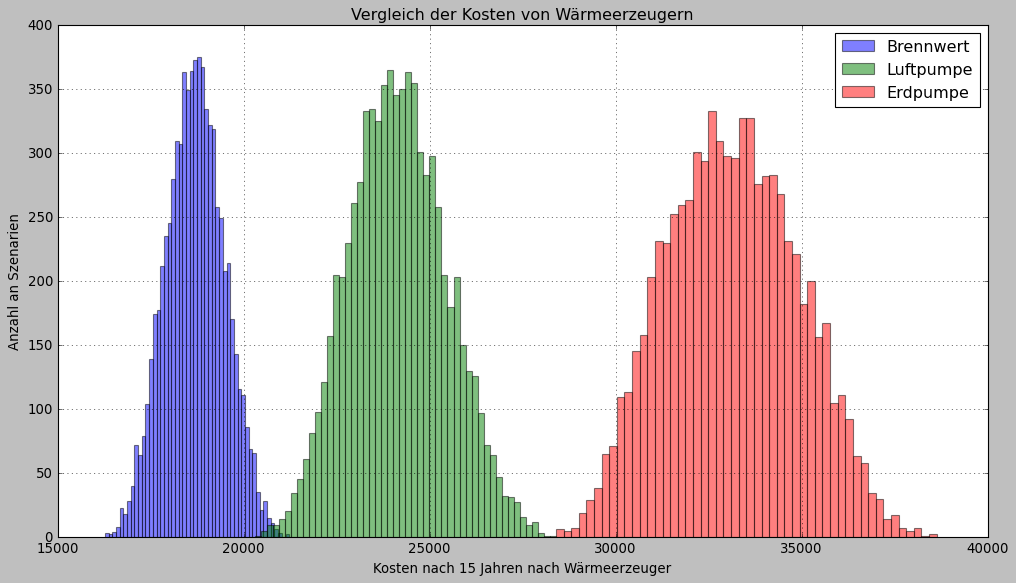

In [29]:
plt.figure(figsize=(15,8)) #, facecolor="white")
plt.hist(Brennwert_Kosten_Gesamt, alpha=0.5, label="Brennwert", bins=50)
plt.hist(Luftpumpe_Kosten_Gesamt, alpha=0.5, label="Luftpumpe", bins=50)
plt.hist(Erdpumpe_Kosten_Gesamt, alpha=0.5, label="Erdpumpe", bins=50)
plt.title("Vergleich der Kosten von Wärmeerzeugern")
plt.xlabel("Kosten nach 15 Jahren nach Wärmeerzeuger")
plt.ylabel("Anzahl an Szenarien")
plt.legend()
plt.grid()
plt.show()